In [20]:
from tensorflow.keras.layers import Input, Lambda, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import plot_model
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, concatenate, UpSampling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy

In [22]:
IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_CHANNELS = 3

path = '/kaggle/input/luna16ds/Luna16_Data/'
X = []
Y = []
for foldername in os.listdir(path):
    if foldername.startswith('images'):
        for filename in os.listdir(os.path.join(path, foldername)):
            img = cv2.imread(os.path.join(path, foldername, filename))
            img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))
            X.append(img)
    elif foldername.startswith('masks'):
        for filename in os.listdir(os.path.join(path, foldername)):
            mask = cv2.imread(os.path.join(path, foldername, filename), 0)
            mask = cv2.resize(mask, (IMG_WIDTH, IMG_HEIGHT))
            mask = np.expand_dims(mask, axis=-1)
            Y.append(mask)

X = np.array(X) / 255.0
Y = np.array(Y) / 255.0
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [23]:
# define the U-Net model architecture
inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = Lambda(lambda x: x / 255) (inputs)

# Contracting Path
c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (s)
c1 = Dropout(0.1) (c1)
c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p1)
c2 = Dropout(0.1) (c2)
c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p2)
c3 = Dropout(0.2) (c3)
c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p3)
c4 = Dropout(0.2) (c4)
c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p4)
c5 = Dropout(0.3) (c5)
c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c5)

u6 = UpSampling2D(size=(2, 2)) (c5)
u6 = Conv2D(128, (2, 2), activation='relu', kernel_initializer='he_normal', padding='same') (u6)
u6 = concatenate([u6, c4])
c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u6)
c6 = Dropout(0.2) (c6)
c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c6)

u7 = UpSampling2D(size=(2, 2)) (c6)
u7 = Conv2D(64, (2, 2), activation='relu', kernel_initializer='he_normal', padding='same') (u7)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u7)
c7 = Dropout(0.2) (c7)
c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c7)

u8 = UpSampling2D(size=(2, 2)) (c7)
u8 = Conv2D(32, (2, 2), activation='relu', kernel_initializer='he_normal', padding='same') (u8)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u8)
c8 = Dropout(0.1) (c8)
c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c8)

u9 = UpSampling2D(size=(2, 2)) (c8)
u9 = Conv2D(16, (2, 2), activation='relu', kernel_initializer='he_normal', padding='same') (u9)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u9)
c9 = Dropout(0.1) (c9)
c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

In [24]:
model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 lambda_2 (Lambda)              (None, 256, 256, 3)  0           ['input_4[0][0]']                
                                                                                                  
 conv2d_29 (Conv2D)             (None, 256, 256, 16  448         ['lambda_2[0][0]']               
                                )                                                                 
                                                                                            

In [25]:
data_gen_args = dict(rotation_range=0.2,
width_shift_range=0.05,
height_shift_range=0.05,
shear_range=0.05,
zoom_range=0.05,
horizontal_flip=True,
fill_mode='nearest')

image_datagen = ImageDataGenerator(**data_gen_args)
mask_datagen = ImageDataGenerator(**data_gen_args)

seed = 42

In [26]:
train_image_generator = image_datagen.flow(X_train, seed=seed, batch_size=BATCH_SIZE, shuffle=True)
train_mask_generator = mask_datagen.flow(Y_train, seed=seed, batch_size=BATCH_SIZE, shuffle=True)
val_image_generator = image_datagen.flow(X_test, seed=seed, batch_size=BATCH_SIZE, shuffle=True)
val_mask_generator = mask_datagen.flow(Y_test, seed=seed, batch_size=BATCH_SIZE, shuffle=True)

train_generator = zip(train_image_generator, train_mask_generator)
val_generator = zip(val_image_generator, val_mask_generator)

earlystopper = EarlyStopping(patience=5, verbose=1)
checkpointer = ModelCheckpoint('model-tgs_salt_1.h5', verbose=1, save_best_only=True)

In [28]:
results = model.fit_generator(train_generator, validation_data=val_generator, validation_steps=len(X_test) // BATCH_SIZE, steps_per_epoch=len(X_train) // BATCH_SIZE, epochs=10, callbacks=[earlystopper, checkpointer])

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """Entry point for launching an IPython kernel.


Epoch 1/10
19/19 [==============================] - ETA: 0s - loss: 0.7176 - accuracy: 0.6838 
Epoch 1: val_loss improved from inf to 0.63620, saving model to model-tgs_salt_1.h5
19/19 [==============================] - 674s 35s/step - loss: 0.7176 - accuracy: 0.6838 - val_loss: 0.6362 - val_accuracy: 0.6974
Epoch 2/10
19/19 [==============================] - ETA: 0s - loss: 0.5799 - accuracy: 0.6999 
Epoch 2: val_loss improved from 0.63620 to 0.53308, saving model to model-tgs_salt_1.h5
19/19 [==============================] - 652s 35s/step - loss: 0.5799 - accuracy: 0.6999 - val_loss: 0.5331 - val_accuracy: 0.6947
Epoch 3/10
19/19 [==============================] - ETA: 0s - loss: 0.5275 - accuracy: 0.6927 
Epoch 3: val_loss improved from 0.53308 to 0.50612, saving model to model-tgs_salt_1.h5
19/19 [==============================] - 643s 34s/step - loss: 0.5275 - accuracy: 0.6927 - val_loss: 0.5061 - val_accuracy: 0.6931
Epoch 4/10
19/19 [==============================] - ETA: 0s - 

In [32]:
from keras.models import load_model
def iou_score(y_true, y_pred, smooth=1):
    intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
    union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
    iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
    return iou

def dice_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(y_true * y_pred, axis=[1,2,3])
    union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
    dice = K.mean((2. * intersection + smooth)/(union + smooth), axis=0)
    return dice

model = load_model('model-tgs_salt_1.h5', custom_objects={'iou_score': iou_score, 'dice_coef': dice_coef})
y_pred = model.predict(X_test)

10/10 [==============================] - 36s 4s/step


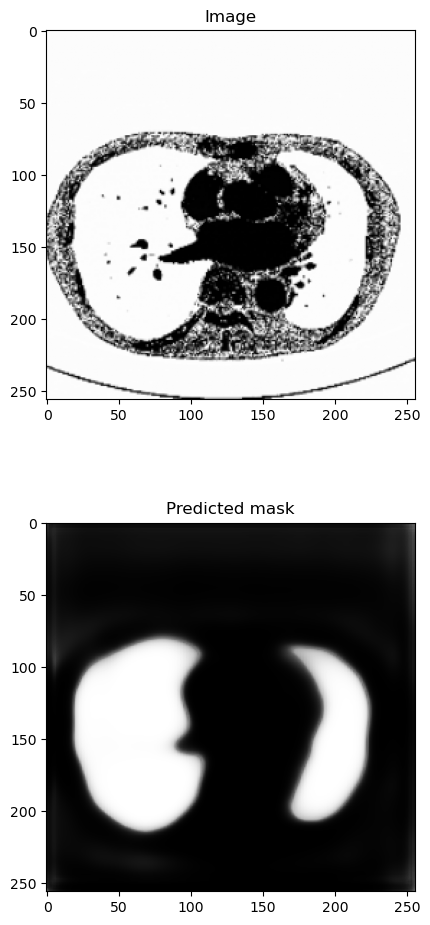

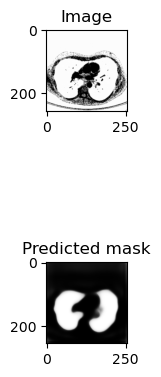

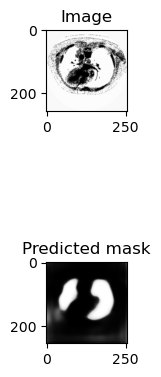

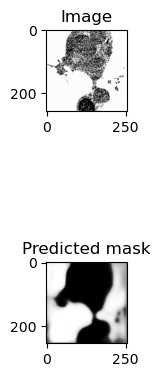

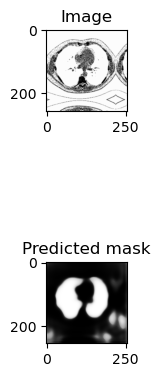

In [35]:
plt.figure(figsize=(20,10))
for i in range(5):
    plt.subplot(2,5,i+1)
    plt.imshow(X_test[i])
    plt.title('Image')
    plt.subplot(2,5,i+6)
    plt.imshow(y_pred[i].reshape(256, 256), cmap='gray')
    plt.title('Predicted mask')

    plt.tight_layout()
    plt.show()

In [37]:
_, acc = model.evaluate(X_test, Y_test)
print("Accuracy on test set: {:.2f}%".format(acc*100))

10/10 [==============================] - 34s 3s/step - loss: 0.1130 - accuracy: 0.9480
Accuracy on test set: 94.80%


In [41]:
for i in range(len(X_test)):
    pred_mask = y_pred[i].reshape(256, 256)
    pred_mask = (pred_mask > 0.5).astype(np.uint8) * 255
    cv2.imwrite("pred_mask_{}.png".format(i), pred_mask)

    true_mask = Y_test[i].reshape(256, 256)
    true_mask = (true_mask > 0.5).astype(np.uint8) * 255
    cv2.imwrite("true_mask_{}.png".format(i), true_mask)

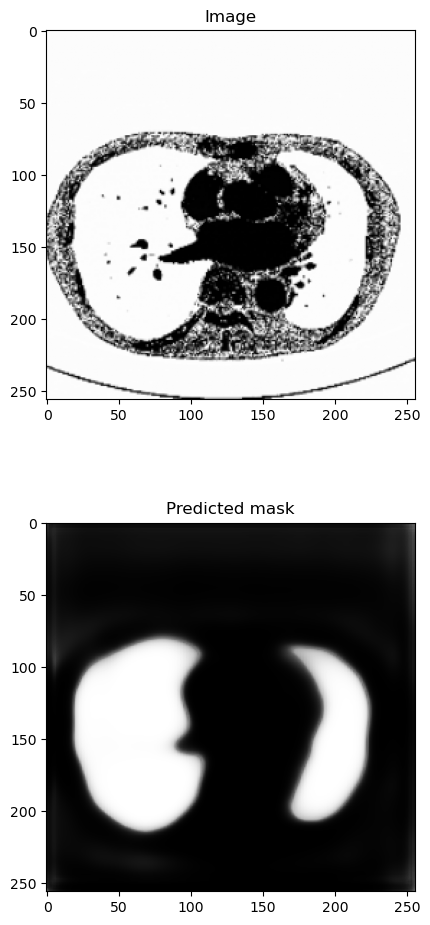

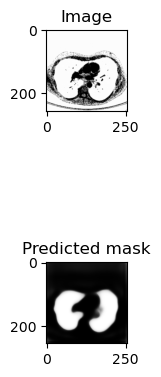

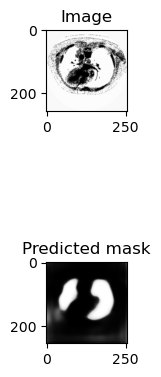

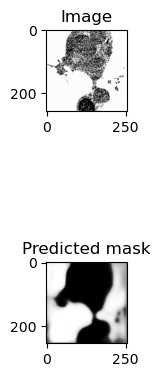

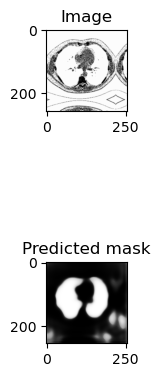

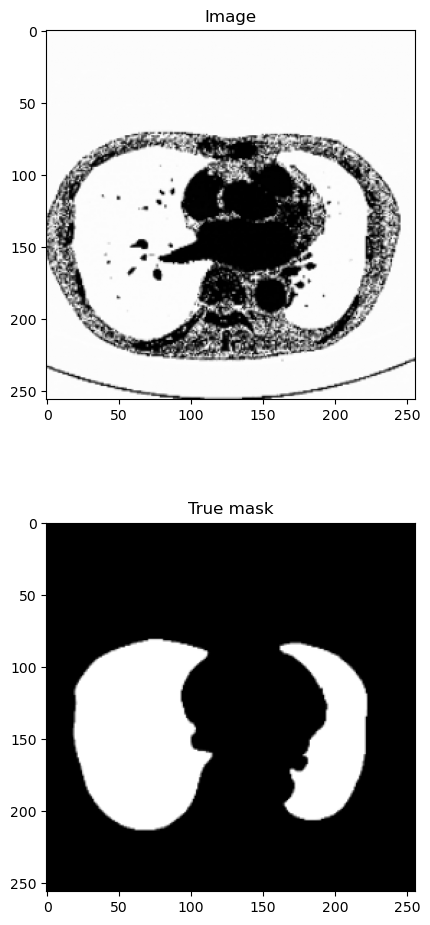

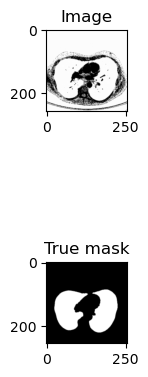

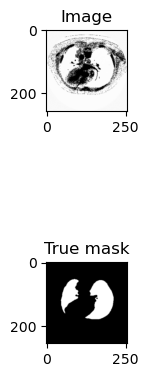

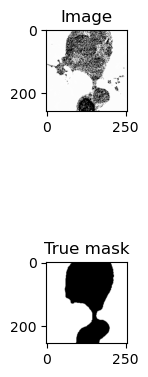

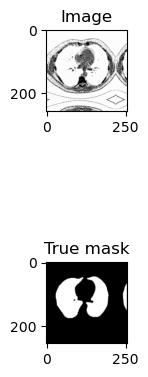

In [45]:
plt.figure(figsize=(20,10))
for i in range(5):
    plt.subplot(2,5,i+1)
    plt.imshow(X_test[i])
    plt.title('Image')
    plt.subplot(2,5,i+6)
    plt.imshow(y_pred[i].reshape(256,256), cmap='gray')
    plt.title('Predicted mask')

    plt.tight_layout()
    plt.show()

plt.figure(figsize=(20,10))
for i in range(5):
    plt.subplot(2,5,i+1)
    plt.imshow(X_test[i])
    plt.title('Image')
    plt.subplot(2,5,i+6)
    plt.imshow(Y_test[i].reshape(256,256), cmap='gray')
    plt.title('True mask')

    plt.tight_layout()
    plt.show()

In [48]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

y_pred_bin = (y_pred > 0.5).astype(np.uint8)
y_test_bin = (Y_test > 0.5).astype(np.uint8)

conf_mat = confusion_matrix(y_test_bin.ravel(), y_pred_bin.ravel())
print("Confusion matrix:\n", conf_mat)

precision = precision_score(y_test_bin.ravel(), y_pred_bin.ravel())
print("Precision: {:.2f}%".format(precision*100))

recall = recall_score(y_test_bin.ravel(), y_pred_bin.ravel())
print("Recall: {:.2f}%".format(recall*100))

f1 = f1_score(y_test_bin.ravel(), y_pred_bin.ravel())
print("F1 score: {:.2f}%".format(f1*100))

Confusion matrix:
 [[14301123   348246]
 [  410397  5387466]]
Precision: 93.93%
Recall: 92.92%
F1 score: 93.42%
